# GAN on MNIST
Following [this](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/) tutorial

In [34]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
def xavier_init(size):
    """
    Xavier Initialization
    See:  https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
    """
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [4]:
# Discriminator Net
X = tf.placeholder(tf.float32, shape=[None, 784], name='X')

D_W1 = tf.Variable(xavier_init([784, 128]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')

D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = tf.Variable(xavier_init([100, 128]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')

G_W2 = tf.Variable(xavier_init([128, 784]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[784]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [5]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [6]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [32]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [72]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

## Loss Functions

In [80]:
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake)) # Original blog - leads to mode collapse for me
G_loss = tf.reduce_mean(tf.log(1. - D_fake)) # From paper (ignoring hint, which I think was meant for early training)

In [93]:
# Sigmoid cross entropy (assumes non-mutually exclusive classes)
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) #original
G_loss = -D_loss_fake

## Training

In [94]:
mb_size = 128
Z_dim = 100

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [95]:
if not os.path.exists('out_v3/'):
    os.makedirs('out_v3/')

In [96]:
# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

In [97]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [98]:
i = 0
D_iter = 1 # Number of D iters per loop
G_iter = 1 # Number of G iters per loop

for it in range(int(1e5)):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out_v3/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    
    for j in range(D_iter):
        X_mb, _ = mnist.train.next_batch(mb_size)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    
    for k in range(G_iter):
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
    

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.294
G_loss: -0.05065

Iter: 1000
D loss: 0.002846
G_loss: -0.001358

Iter: 2000
D loss: 0.0003328
G_loss: -0.0002206

Iter: 3000
D loss: 0.0001301
G_loss: -6.065e-05

Iter: 4000
D loss: 0.000235
G_loss: -7.237e-05

Iter: 5000
D loss: 0.008195
G_loss: -0.004061

Iter: 6000
D loss: 2.277e-05
G_loss: -1.709e-06

Iter: 7000
D loss: 1.901e-06
G_loss: -6.755e-07

Iter: 8000
D loss: 9.836e-07
G_loss: -2.081e-07

Iter: 9000
D loss: 5.69e-07
G_loss: -1.069e-07

Iter: 10000
D loss: 9.086e-07
G_loss: -1.097e-07

Iter: 11000
D loss: 1.586e-07
G_loss: -1.212e-08

Iter: 12000
D loss: 5.45e-08
G_loss: -2.31e-08

Iter: 13000
D loss: 4.403e-07
G_loss: -2.288e-08

Iter: 14000
D loss: 6.095e-08
G_loss: -1.648e-08

Iter: 15000
D loss: 6.57e-08
G_loss: -1.071e-08

Iter: 16000
D loss: 3.436e-09
G_loss: -4.069e-09

Iter: 17000
D loss: 1.032e-08
G_loss: -6.274e-09

Iter: 18000
D loss: 2.449e-08
G_loss: -1.496e-09

Iter: 19000
D loss: 3.084e-09
G_loss: -2.751e-09

Iter: 20000
D loss: 8.475e-1

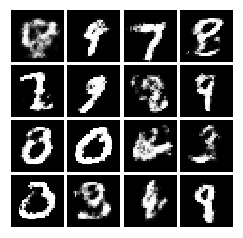

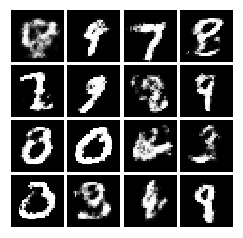

In [100]:
plot(samples)